In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

import umap
from sklearn.preprocessing import MinMaxScaler 

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [9]:
LABELS = np.array(["Train", "CIFAR", "CelebA", "SVHN"])
colors = ["red", "blue", "green", "orange"]

## Train Data = L2-norm(Pixel Scores)

In [5]:
from ood_detection_helper import *
import pickle

Parameters: 

experiment: train
dataset: mnist
model: refinenet
filters: 128
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: ./saved_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: False
max_to_keep: 2



In [6]:
with open("scores.p", "rb") as f:
    score_dict = pickle.load(f)
score_dict.keys()

dict_keys(['cifar', 'celeba', 'svhn'])

In [7]:
test_data = score_dict["cifar"]
outlier_data_1 = score_dict["celeba"]
outlier_data_2 = score_dict["svhn"]

In [10]:
# Shapes
shapes = [test_data.shape, outlier_data_1.shape, outlier_data_2.shape]

samples = np.concatenate((test_data, outlier_data_1, outlier_data_2))

labels = np.concatenate((np.zeros(test_data.shape[0]),
                         np.ones(outlier_data_1.shape[0]),
                         2*np.ones(outlier_data_2.shape[0])))

captions = np.concatenate([[LABELS[idx]]*shapes[idx-1][0] for idx in range(1,4)])

In [69]:
X_train, X_test =  test_data[:9000], test_data[9000:]
outlier_train = np.concatenate((outlier_data_1[9000:], outlier_data_2[9000:]))

## PCA

In [64]:
from sklearn.decomposition import PCA, KernelPCA

samples_train = np.concatenate((test_data[:9000], outlier_data_1[:9000], outlier_data_2[:9000]))
samples_test  = np.concatenate((test_data[9000:], outlier_data_1[9000:], outlier_data_2[9000:]))

samples_train.shape

(27000, 10)

In [65]:
%%time

reducer = PCA(n_components=3)
reducer.fit(samples_train)
print(reducer.explained_variance_ratio_)

[0.6848513  0.26766035 0.03286991]
CPU times: user 1.13 s, sys: 2.26 s, total: 3.39 s
Wall time: 79.3 ms


In [66]:
%%time
embedding = reducer.transform(samples_test)
embedding.shape

CPU times: user 0 ns, sys: 1.02 ms, total: 1.02 ms
Wall time: 751 µs


(3000, 3)

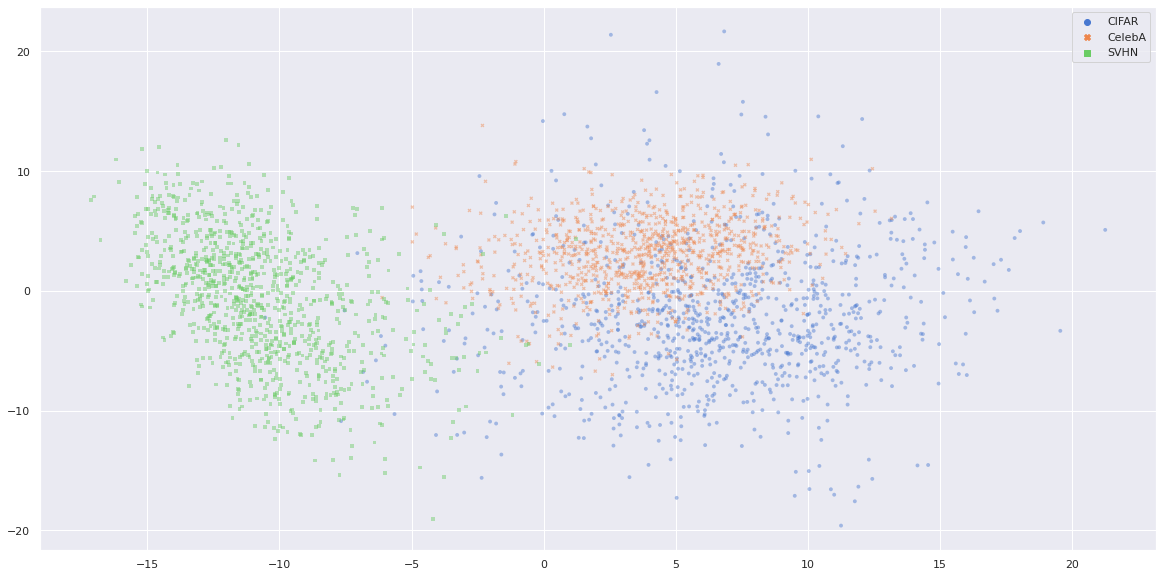

In [67]:
plt.figure(figsize=(20,10))

captions_test = np.concatenate([[LABELS[idx]]*(shapes[idx-1][0]-9000) for idx in range(1,4)])
labels_test = np.concatenate([[idx]*(shapes[idx-1][0]-9000) for idx in range(1,4)])
sns.scatterplot(x=embedding[:, 0],
                y=embedding[:, 1],
                hue=captions_test, style=captions_test, s=15, alpha=0.45, palette="muted", edgecolor="none")
plt.show()
# plt.close()

In [68]:
emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Score Norms",
    marker=dict(
        size=2,
        color=labels_test,
        colorscale="Blackbody",
        opacity=0.5,
        showscale=True
    ),
    text=captions_test
)

layout = go.Layout(
    title="3D UMAP",
    autosize=False,
    width=1000,
    height=800,
#     paper_bgcolor='#F5F5F5',
#     template="plotly"
)

data=[emb3d]

fig = go.Figure(data=data, layout=layout)
fig.show("notebook")

In [70]:
%%time
X_train_embedding = reducer.transform(X_train)
X_test_embedding = reducer.transform(X_test)
outlier_train_embedding = reducer.transform(outlier_train)

outlier_1_embedding = reducer.transform(outlier_data_1[9000:])
outlier_2_embedding = reducer.transform(outlier_data_2[9000:])

CPU times: user 57.7 ms, sys: 72 ms, total: 130 ms
Wall time: 4.19 ms


## GMM - Likelihood Based

In [71]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(2,21,2),
                  GMM__covariance_type = ['full']) # Full always performs best 

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(X_train_embedding)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    3.1s finished


CPU times: user 24.5 s, sys: 197 ms, total: 24.7 s
Wall time: 4.08 s


Best: -4.126795 using {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
---------------------------------------------------------------------------
-4.151701 (0.036630) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
-4.141397 (0.034993) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
-4.131796 (0.040518) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
-4.128169 (0.038502) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
-4.126795 (0.040367) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
-4.127227 (0.037912) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
-4.126884 (0.037530) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
-4.129248 (0.038281) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
-4.129694 (0.038231) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
-4.128787 (0.039004) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20

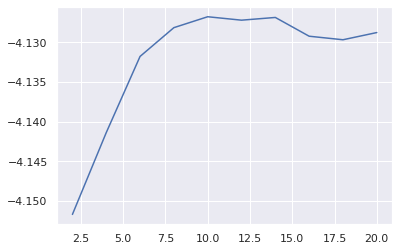

In [72]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
plt.plot([p["GMM__n_components"] for p in params], means)

In [73]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**best_params)
best_gmm_clf.fit(X_train_embedding)

print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_1_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_2_embedding)))

Training Likelihood: -4.118
CIFAR Likelihood: -4.130
CelebA Likelihood: -4.360
SVHN Likelihood: -10.685


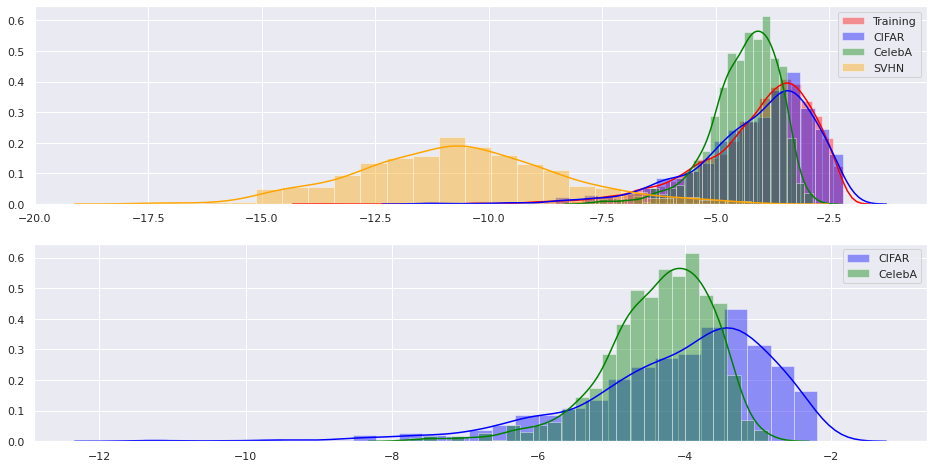

In [74]:
train_score = best_gmm_clf.score_samples(X_train_embedding)
test_score = best_gmm_clf.score_samples(X_test_embedding)
outlier_score = best_gmm_clf.score_samples(outlier_1_embedding)
outlier_score_2 = best_gmm_clf.score_samples(outlier_2_embedding)

fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

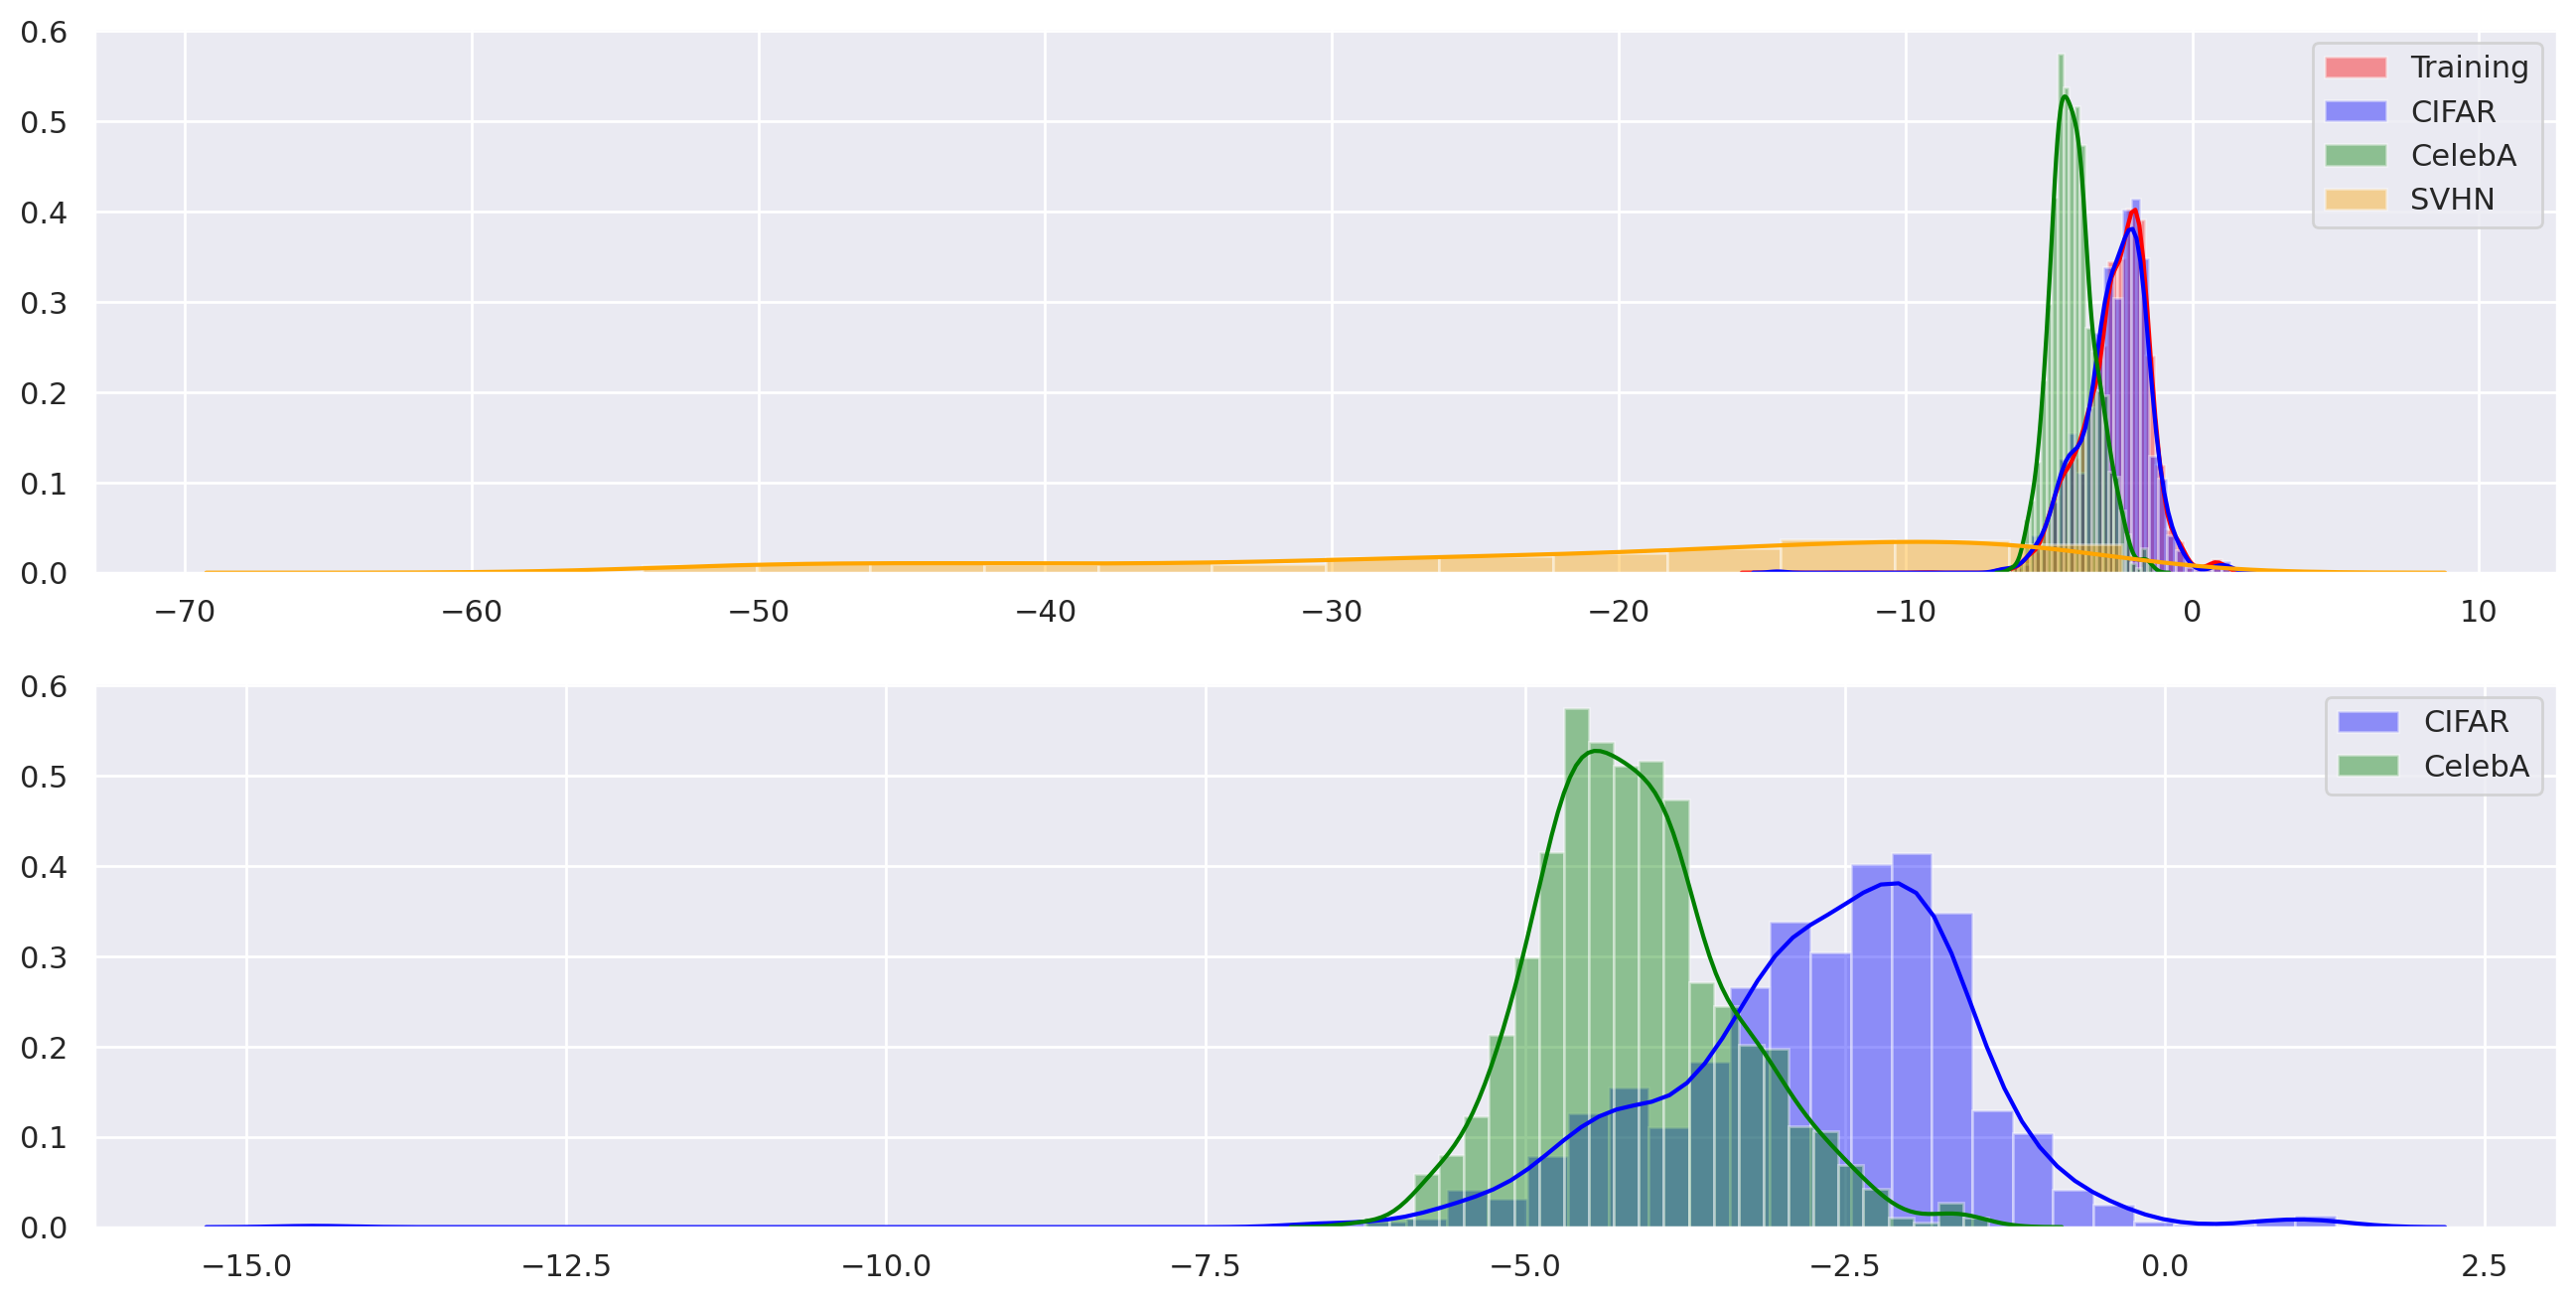

In [145]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

> # TODO: Modify metric function to include AUPR-In vs Out etc and FPR 80

### AUPR-In

In [77]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)
metrics(-test_score, -outlier_score, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9899
PR-AUC: 0.9897
Avg Prec: 0.9897
Inlier vs Outlier
----------------
ROC-AUC: 0.6168
PR-AUC: 0.5252
Avg Prec: 0.5258


(0.616782, 0.5258058262046494, 0.5251696572384441)

In [52]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9904
PR-AUC: 0.9904
Avg Prec: 0.9904


(0.9904379999999999, 0.9904195730764369, 0.9904145038514139)

In [54]:
metrics(outlier_score_2, test_score, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9783
PR-AUC: 0.9203
Avg Prec: 0.9203


(0.9782692999999999, 0.9202829395577422, 0.92025828566857)

# Kernel PCA

In [110]:
%%time

reducer = KernelPCA(n_components=5, kernel="rbf")
reducer.fit(samples_train)

CPU times: user 2min 46s, sys: 3min 5s, total: 5min 52s
Wall time: 32.4 s


KernelPCA(kernel='rbf', n_components=5)

In [111]:
print(reducer.lambdas_)

[1691.0586 1085.753  1064.5032  914.      830.6727]


In [112]:
%%time
embedding = reducer.transform(samples_test)
embedding.shape

CPU times: user 23.4 s, sys: 1min 50s, total: 2min 13s
Wall time: 3.83 s


(3000, 5)

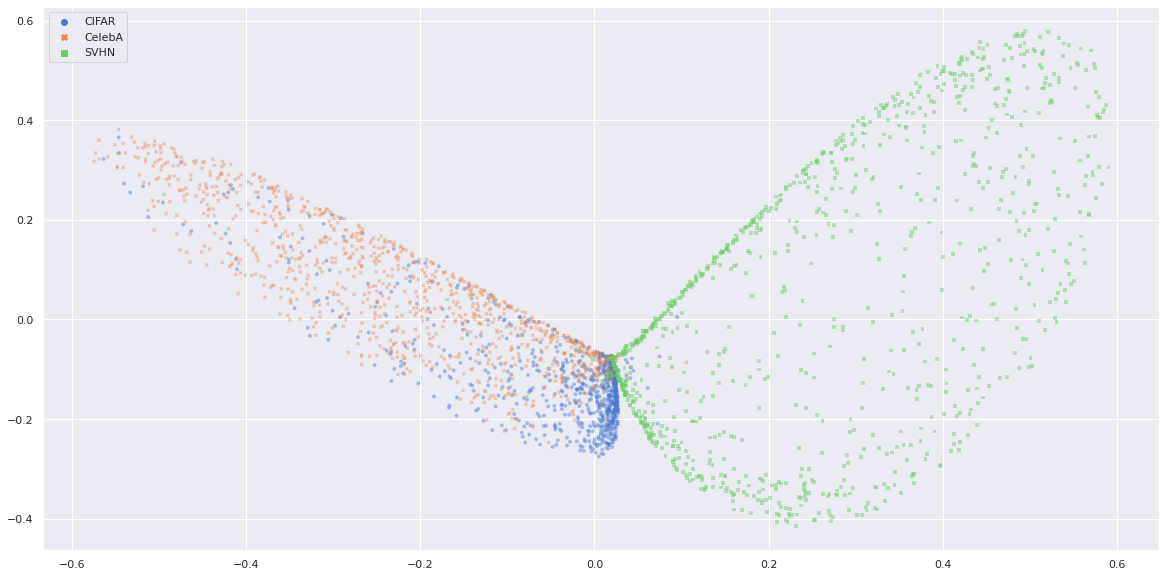

In [113]:
plt.figure(figsize=(20,10))

captions_test = np.concatenate([[LABELS[idx]]*(shapes[idx-1][0]-9000) for idx in range(1,4)])
labels_test = np.concatenate([[idx]*(shapes[idx-1][0]-9000) for idx in range(1,4)])
sns.scatterplot(x=embedding[:, 0],
                y=embedding[:, 1],
                hue=captions_test, style=captions_test, s=15, alpha=0.45, palette="muted", edgecolor="none")
plt.show()
# plt.close()

In [114]:
emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Score Norms",
    marker=dict(
        size=2,
        color=labels_test,
        colorscale="Blackbody",
        opacity=0.5,
        showscale=True
    ),
    text=captions_test
)

layout = go.Layout(
    title="3D UMAP",
    autosize=False,
    width=1000,
    height=800,
#     paper_bgcolor='#F5F5F5',
#     template="plotly"
)

data=[emb3d]

fig = go.Figure(data=data, layout=layout)
fig.show("notebook")

In [115]:
%%time
X_train_embedding = reducer.transform(X_train)
X_test_embedding = reducer.transform(X_test)
outlier_train_embedding = reducer.transform(outlier_train)

outlier_1_embedding = reducer.transform(outlier_data_1[9000:]) # Test Samples
outlier_2_embedding = reducer.transform(outlier_data_2[9000:]) # Test Samples

CPU times: user 1min 20s, sys: 5min 5s, total: 6min 26s
Wall time: 15.9 s


## GMM - Likelihood Based

In [116]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(2,21,2),
                  GMM__covariance_type = ['full']) # Full always performs best 

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(X_train_embedding)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   22.0s finished


CPU times: user 51.2 s, sys: 1.08 s, total: 52.3 s
Wall time: 25.2 s


/usr/local/lib/python3.6/dist-packages/scikit_learn-0.23.1-py3.6-linux-x86_64.egg/sklearn/mixture/_base.py:269: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



Best: 6.062716 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
0.123629 (1.002141) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
3.749700 (0.319466) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
4.472503 (0.373322) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
4.897337 (0.327344) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
5.204839 (0.317467) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
5.510489 (0.323487) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
5.716984 (0.275818) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
5.856000 (0.303510) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
5.988305 (0.301860) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
6.062716 (0.306641) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


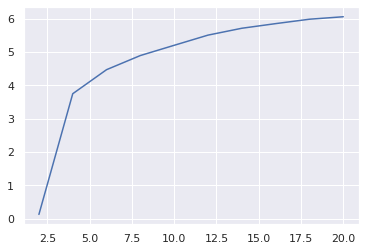

In [117]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
plt.plot([p["GMM__n_components"] for p in params], means)

In [118]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**best_params)
best_gmm_clf.fit(X_train_embedding)

print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_1_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_2_embedding)))

Training Likelihood: 6.122
CIFAR Likelihood: 5.946
CelebA Likelihood: -1.598
SVHN Likelihood: -109.388


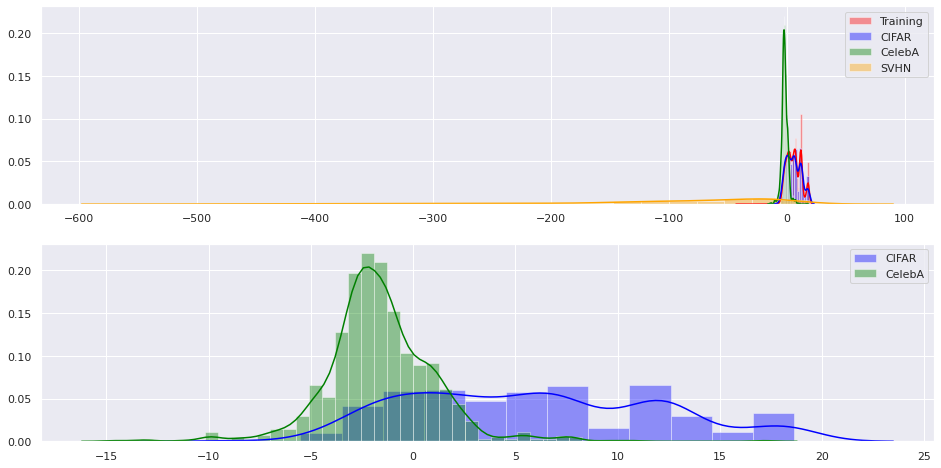

In [119]:
train_score = best_gmm_clf.score_samples(X_train_embedding)
test_score = best_gmm_clf.score_samples(X_test_embedding)
outlier_score = best_gmm_clf.score_samples(outlier_1_embedding)
outlier_score_2 = best_gmm_clf.score_samples(outlier_2_embedding)

fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

> # TODO: Modify metric function to include AUPR-In vs Out etc and FPR 80

### AUPR-In

In [120]:
metrics(-test_score, -outlier_score_2[0:-1:10], plot=False, verbose=True)
metrics(-test_score, -outlier_score[0:-1:10], plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9908
PR-AUC: 0.9599
Avg Prec: 0.9600
Inlier vs Outlier
----------------
ROC-AUC: 0.8752
PR-AUC: 0.3788
Avg Prec: 0.3834


(0.87522, 0.38343594671937065, 0.3787619526425341)

In [52]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9904
PR-AUC: 0.9904
Avg Prec: 0.9904


(0.9904379999999999, 0.9904195730764369, 0.9904145038514139)

In [54]:
metrics(outlier_score_2, test_score, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9783
PR-AUC: 0.9203
Avg Prec: 0.9203


(0.9782692999999999, 0.9202829395577422, 0.92025828566857)

In [39]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score

def evaluate_GMM_emb(n):
    gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
    ]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': n})
    
    gmm_clf.fit(X_train_embedding)
    
    test_score = gmm_clf.score_samples(X_test_embedding)
    outlier_score = gmm_clf.score_samples(outlier_train_embedding)
    
    y_true = np.concatenate((np.zeros(len(test_score)),
                             np.ones(len(outlier_score))
                            ))
    
    y_scores = -np.concatenate((test_score, outlier_score))


    roc_auc = roc_auc_score(y_true,y_scores)
    
    return roc_auc

In [43]:
# %%time


# with ThreadPoolExecutor(max_workers = 4) as exc:
#     result = list(exc.map(evaluate_GMM, component_range))

In [42]:
%%time

max_n_component = 20
component_range = range(2, max_n_component+1, 2)

result = [evaluate_GMM_emb(n) for n in component_range]
result = np.array(result)

CPU times: user 1min 47s, sys: 3.23 s, total: 1min 50s
Wall time: 3.46 s


Best -> n=14: 0.810 


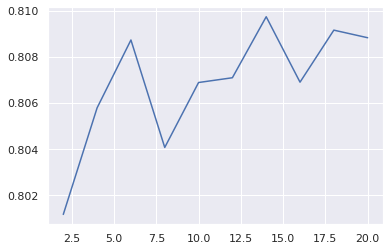

In [43]:
plt.plot(component_range, result)

print("Best -> n={}: {:.3f} ".format(component_range[np.argmax(result)], np.max(result)))

In [61]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
#     ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**{"GMM__n_components":38})

best_gmm_clf.fit(X_train)

Pipeline(steps=[('GMM', GaussianMixture(n_components=38))])

In [62]:
print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_data_1)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_data_2)))

Training Likelihood: -6.034
CIFAR Likelihood: -6.370
CelebA Likelihood: -8.289
SVHN Likelihood: -16.557


In [63]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

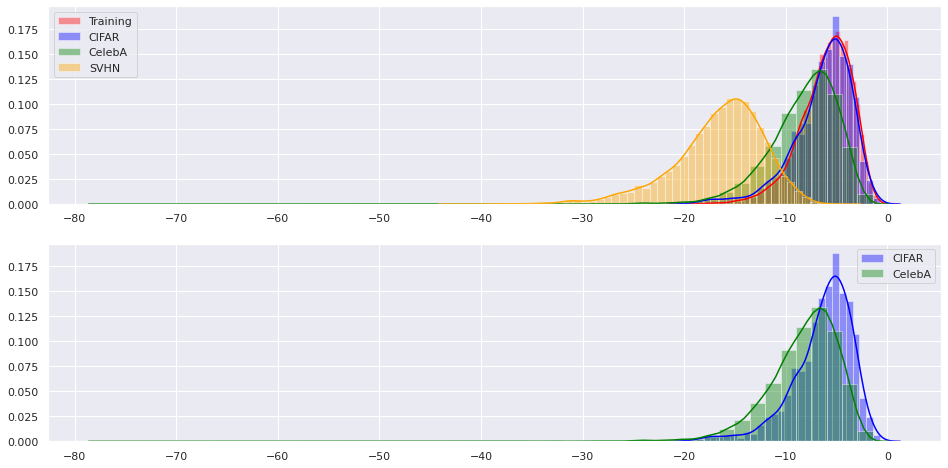

In [64]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

### AUPR-In

In [52]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9783
PR-AUC: 0.9970
Avg Prec: 0.9970


In [54]:
metrics(outlier_score_2, test_score, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9783
PR-AUC: 0.9203
Avg Prec: 0.9203


(0.9782692999999999, 0.9202829395577422, 0.92025828566857)

In [28]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(2,21,2),
                  GMM__covariance_type = ['full']) # Full always performs best 

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(X_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   25.5s finished


CPU times: user 1min 34s, sys: 1min 23s, total: 2min 58s
Wall time: 29.4 s


Best: 2.357059 using {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
---------------------------------------------------------------------------
2.041103 (0.106443) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.250167 (0.092722) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.318037 (0.101584) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.351245 (0.091468) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.349406 (0.090313) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
2.357059 (0.091248) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
2.347783 (0.098766) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
2.344918 (0.096629) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
2.333245 (0.100364) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
2.318454 (0.092045) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


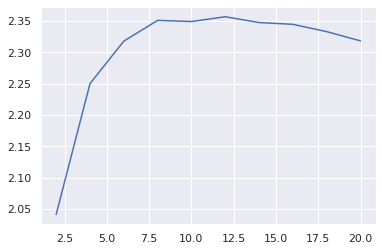

In [29]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
plt.plot([p["GMM__n_components"] for p in params], means)

In [34]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**best_params)

best_gmm_clf.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('GMM', GaussianMixture(n_components=12))])

In [35]:
print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_data_1)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_data_2)))

Training Likelihood: 2.485
CIFAR Likelihood: 2.494
CelebA Likelihood: 0.675
SVHN Likelihood: -6.140


In [36]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

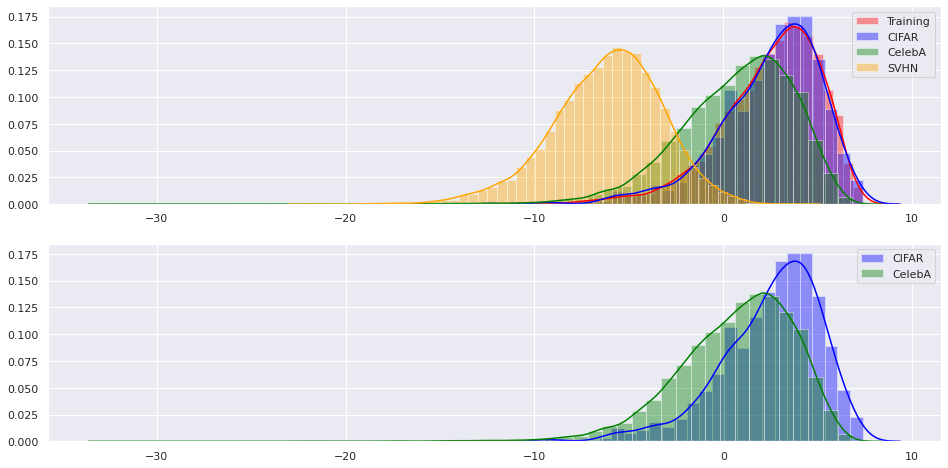

In [37]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

**CIFAR vs CelebA**

In [72]:
metrics(-test_score, -outlier_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.6519
PR-AUC: 0.9421
Avg Prec: 0.9421


**CIFAR vs SVHN**

In [81]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9706
PR-AUC: 0.9955
Avg Prec: 0.9955


### Flow Models

In [57]:
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [58]:
X_train.shape

(9000, 10)

In [59]:
scaler = StandardScaler()
s_X_train = scaler.fit_transform(X_train)

In [ ]:
# Density estimation with MADE.
n = X_train.shape[0]
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[256, 256], activation="relu")

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[10])

# Construct and fit model.
x_ = tfkl.Input(shape=(10,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adadelta(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob)

batch_size = 64
epochs = 500
history = model.fit(
    x=s_X_train,
    y=np.zeros((n, 0), dtype=np.float32),
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=n//batch_size,  # Usually `n // batch_size`.
    shuffle=True,
    verbose=True)

Epoch 1/500
140/140 [==============================] - 0s 3ms/step - loss: 14.1744
Epoch 2/500
140/140 [==============================] - 0s 3ms/step - loss: 14.0650
Epoch 3/500
140/140 [==============================] - 0s 3ms/step - loss: 13.9854
Epoch 4/500
140/140 [==============================] - 0s 3ms/step - loss: 13.8852
Epoch 5/500
140/140 [==============================] - 0s 3ms/step - loss: 13.8076
Epoch 6/500
140/140 [==============================] - 0s 3ms/step - loss: 13.7056
Epoch 7/500
140/140 [==============================] - 0s 3ms/step - loss: 13.6195
Epoch 8/500
140/140 [==============================] - 0s 3ms/step - loss: 13.4628
Epoch 9/500
140/140 [==============================] - 0s 3ms/step - loss: 13.3246
Epoch 10/500
140/140 [==============================] - 0s 3ms/step - loss: 13.1951
Epoch 11/500
 19/140 [===>..........................] - ETA: 0s - loss: 13.1078

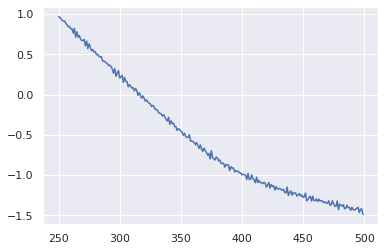

In [92]:
start_idx=250
plt.plot(range(start_idx, epochs), history.history["loss"][start_idx:])
# plt.yscale("log")

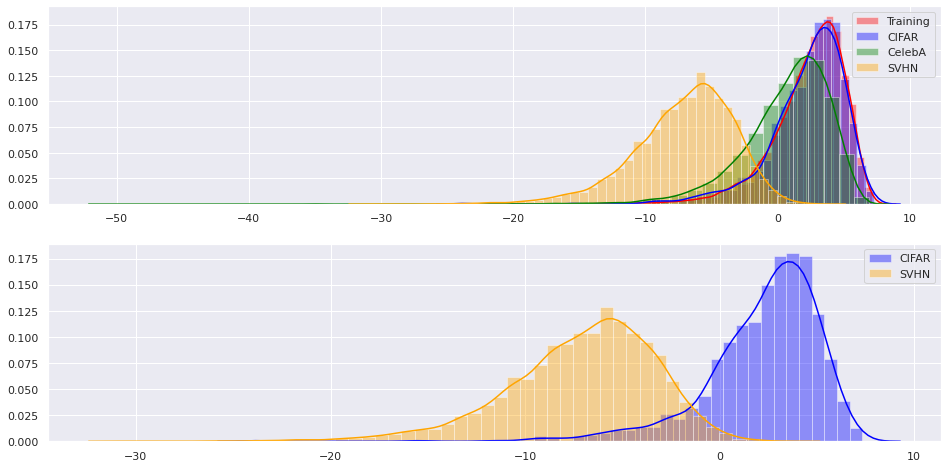

CPU times: user 1.31 s, sys: 20.1 ms, total: 1.33 s
Wall time: 1.32 s


In [87]:
%%time
train_score = distribution.log_prob(scaler.transform(X_train), dtype=np.float32).numpy()
test_score = distribution.log_prob(scaler.transform(X_test), dtype=np.float32).numpy()
outlier_score = distribution.log_prob(scaler.transform(outlier_data_1), dtype=np.float32).numpy()
outlier_score_2 = distribution.log_prob(scaler.transform(outlier_data_2), dtype=np.float32).numpy()

fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

In [79]:
outlier_score_2[0:-1:10].shape

(1000,)

In [89]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)
metrics(outlier_score_2[0:-1:10], test_score, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9736
PR-AUC: 0.9957
Avg Prec: 0.9957
Inlier vs Outlier
----------------
ROC-AUC: 0.9731
PR-AUC: 0.9799
Avg Prec: 0.9799


(0.9730880000000001, 0.9798725853760307, 0.9798645706499773)

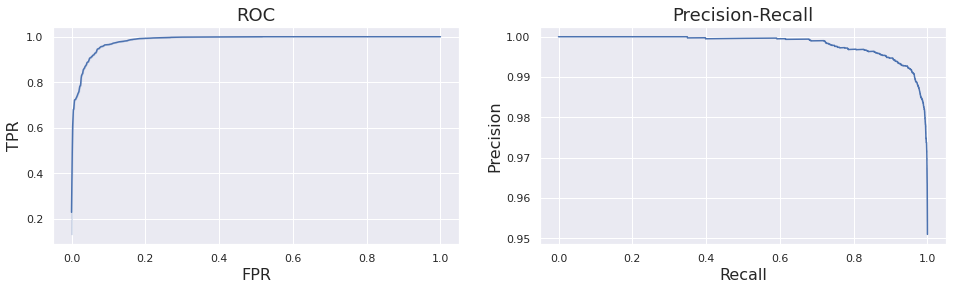

Inlier vs Outlier
----------------
ROC-AUC: 0.9840
PR-AUC: 0.9982
Avg Prec: 0.9982


In [76]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score

def evaluate_GMM_emb(n):
    gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
    ]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': n})
    
    gmm_clf.fit(X_train_embedding)
    
    test_score = gmm_clf.score_samples(X_test_embedding)
    outlier_score = gmm_clf.score_samples(outlier_train_embedding_1)
    outlier_score_2 = gmm_clf.score_samples(outlier_train_embedding_2)
    
    y_true = np.concatenate((np.zeros(len(test_score)),
                             np.ones(len(outlier_score)),
                             np.ones(len(outlier_score_2))
                            ))
    
    y_scores = -np.concatenate((test_score, outlier_score, outlier_score_2))


    roc_auc = roc_auc_score(y_true,y_scores)
    
    return roc_auc

In [ ]:
%%time

max_n_component = 25
component_range = range(1, max_n_component+1, 1)

with ThreadPoolExecutor(max_workers = 4) as exc:
    result = list(exc.map(evaluate_GMM, component_range))
    
result = np.array(result)

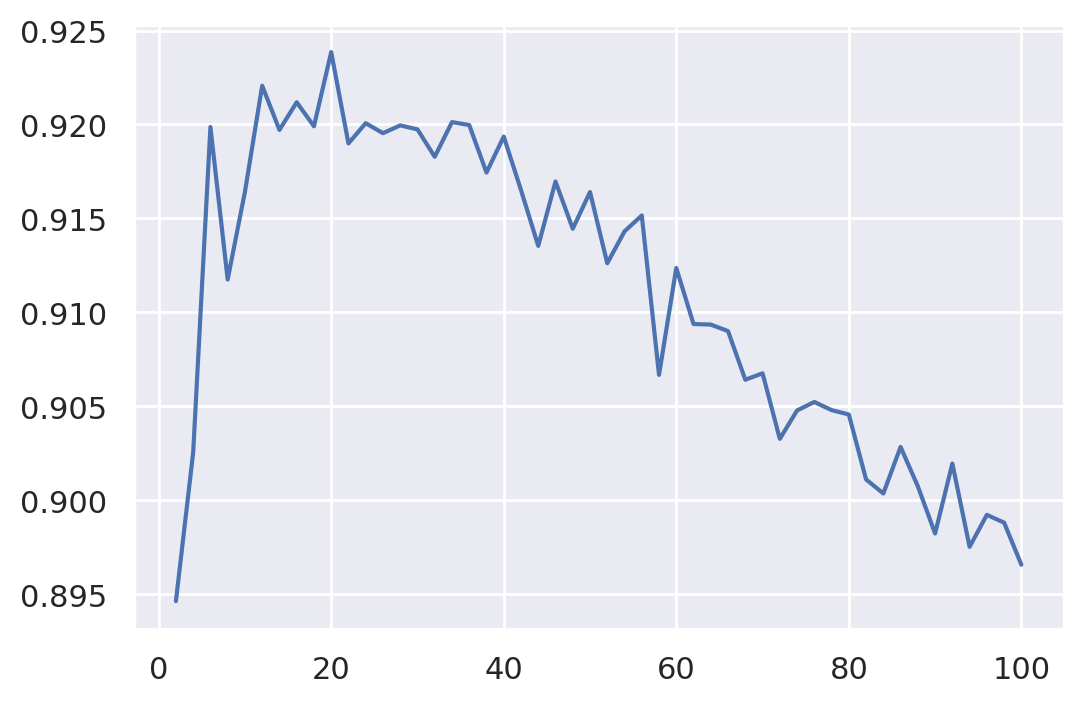

In [166]:
plt.plot(component_range, result)

print("Best -> {}:{:.3f} ".format(component_range[np.argmax(result)], np.max(result)))

In [ ]:
y_true = np.concatenate((np.zeros(len(inlier_score)),
                         np.ones(len(outlier_score))))
y_scores = np.concatenate((inlier_score, outlier_score))


roc_auc = roc_auc_score(y_true,y_scores)

In [151]:
metrics(-test_score, -np.concatenate((outlier_score, outlier_score_2)), plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9197
PR-AUC: 0.9564
Avg Prec: 0.9564


**CIFAR vs CelebA**

In [146]:
metrics(-test_score, -outlier_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.8493
PR-AUC: 0.7716
Avg Prec: 0.7724


**CIFAR vs SVHN**

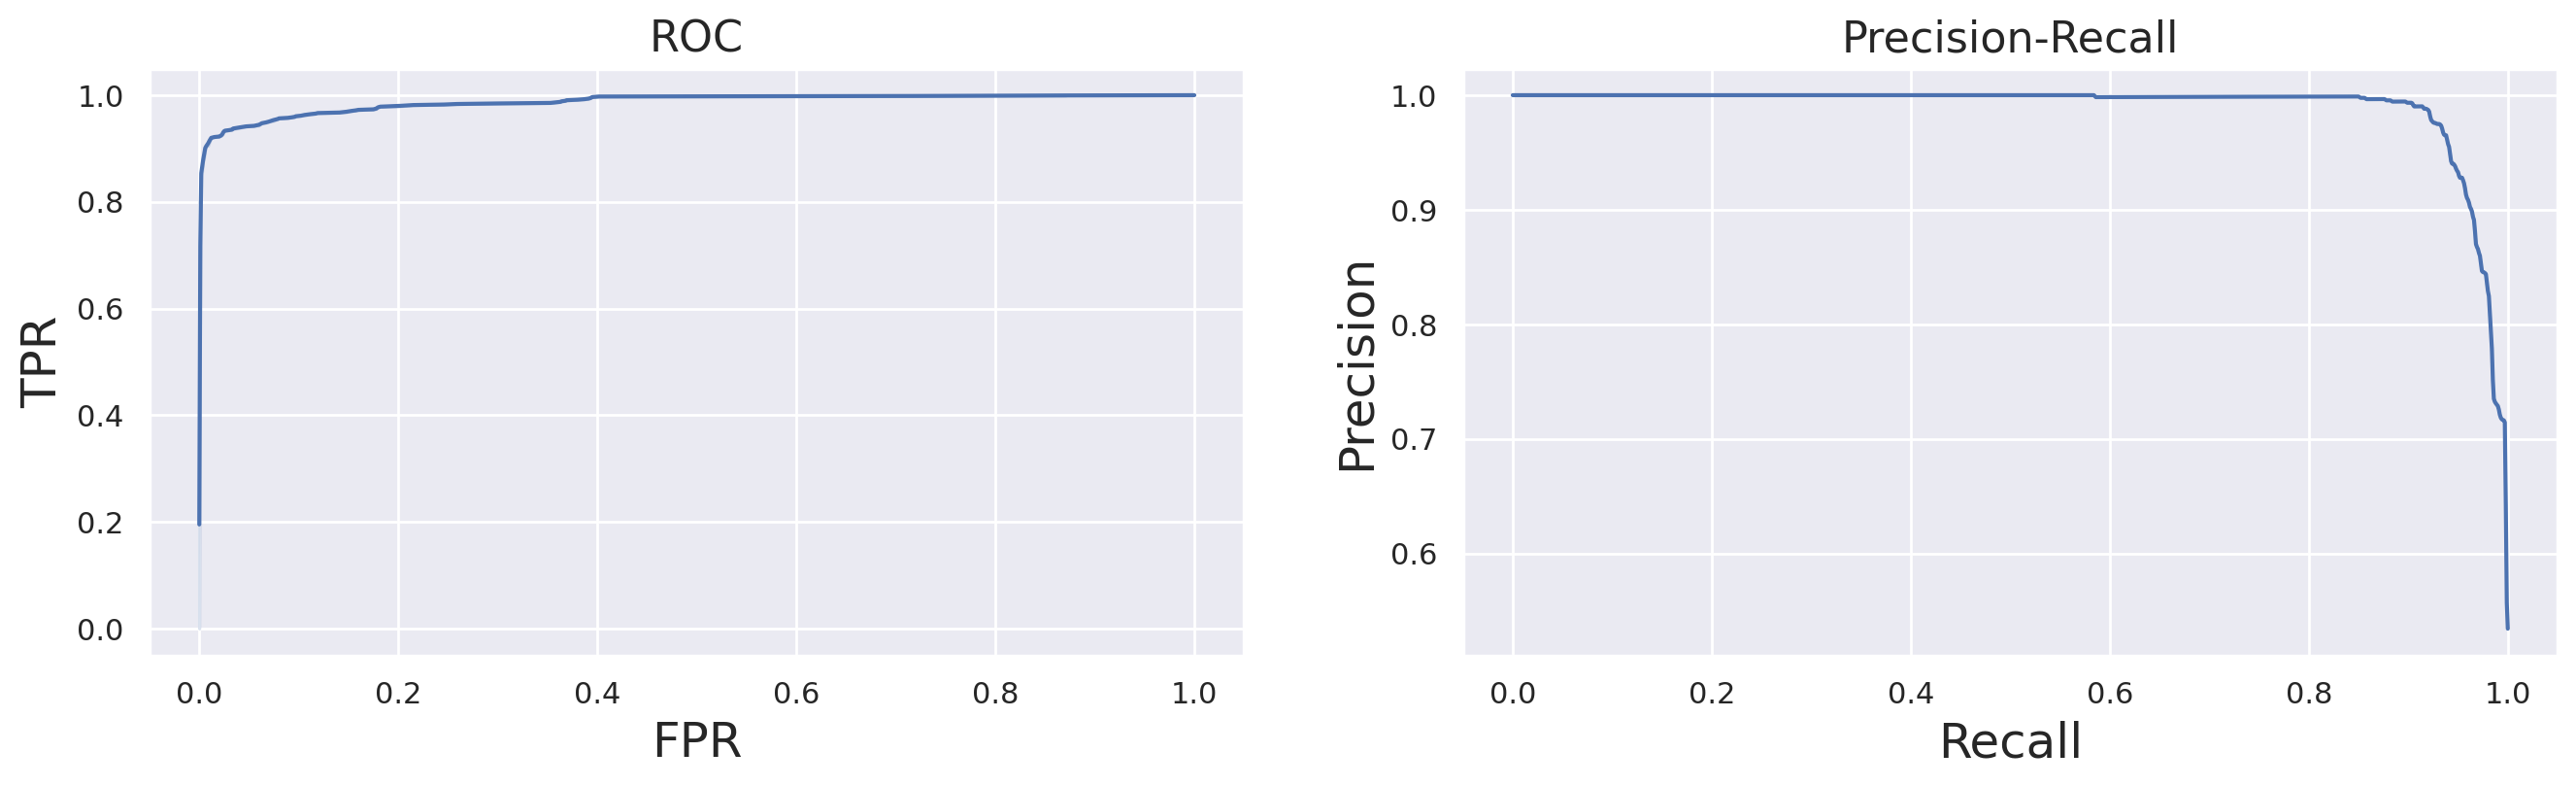

Inlier vs Outlier
----------------
ROC-AUC: 0.9868
PR-AUC: 0.9893
Avg Prec: 0.9893


In [119]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()